In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

In [2]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        
    def fit(self, X: np.ndarray) -> 'StandardScaler':
        """Compute the mean and standard deviation of the input data."""
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=1)
        return self
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """Standardize the input data using pre-computed mean and std."""
        return (X - self.mean_) / self.scale_
        
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """Fit to data, then transform it."""
        return self.fit(X).transform(X)

In [5]:
class PCA:
    def __init__(self, n_components=None, standardize=True):
        """
        Initialize Enhanced PCA.
        
        Parameters:
        -----------
        n_components : int or None
            Number of components to keep
        standardize : bool
            Whether to standardize the data before PCA
        """
        self.n_components = n_components
        self.standardize = standardize
        self.components = None
        self.scaler = StandardScaler() if standardize else None
        self.explained_variance = None
        self.explained_variance_ratio = None
        self.singular_values = None
        
    def fit(self, X):
        """
        Fit the PCA model using SVD.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data.
        """
        n_samples, n_features = X.shape
        
        if self.standardize:
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_scaled = X - np.mean(X, axis=0)
        
        U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)
        
        self.explained_variance = (S ** 2) / (n_samples - 1)
        self.explained_variance_ratio = self.explained_variance / np.sum(self.explained_variance)
        self.singular_values = S
        
        if self.n_components is None:
            self.n_components = n_features
        
        self.components = Vt[:self.n_components]
        
        return self
    
    def transform(self, X):
        """Transform data."""
        if self.standardize:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X - np.mean(X, axis=0)
        return np.dot(X_scaled, self.components.T)
    
    def fit_transform(self, X):
        """Fit and transform data."""
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X_transformed):
        """Inverse transform data back to original space."""
        X_scaled = np.dot(X_transformed, self.components)
        if self.standardize:
            return X_scaled * self.scaler.scale_ + self.scaler.mean_
        return X_scaled + np.mean(X, axis=0)
    
    def plot_explained_variance(self, figsize=(10, 6)):
        """Plot explained variance ratio and cumulative explained variance."""
        plt.figure(figsize=figsize)
        
        plt.bar(range(1, len(self.explained_variance_ratio) + 1),
                self.explained_variance_ratio,
                alpha=0.5,
                align='center',
                label='Individual explained variance')
        
        plt.step(range(1, len(self.explained_variance_ratio) + 1),
                 np.cumsum(self.explained_variance_ratio),
                 where='mid',
                 label='Cumulative explained variance')
        
        plt.xlabel('Principal components')
        plt.ylabel('Explained variance ratio')
        plt.title('Explained Variance Ratio by Principal Components')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    
    def plot_2d_projection(self, X, y=None, figsize=(10, 8)):
        """Plot 2D projection of the data."""
        if self.n_components < 2:
            raise ValueError("n_components must be >= 2 for 2D projection")
        
        X_transformed = self.transform(X)
        
        plt.figure(figsize=figsize)
        scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1],
                            c=y, cmap='viridis' if y is not None else None)
        
        if y is not None:
            plt.colorbar(scatter)
            
        plt.xlabel(f'First Principal Component')
        plt.ylabel(f'Second Principal Component')
        plt.title('2D PCA Projection of the Data')
        plt.grid(True)
        plt.show()
    
    def plot_feature_contributions(self, feature_names=None, figsize=(12, 6)):
        """Plot feature contributions to principal components."""
        if feature_names is None:
            feature_names = [f'Feature {i+1}' for i in range(self.components.shape[1])]
        
        plt.figure(figsize=figsize)
        sns.heatmap(self.components[:2],
                    xticklabels=feature_names,
                    yticklabels=['PC1', 'PC2'],
                    cmap='RdBu',
                    center=0,
                    annot=True)
        plt.title('Feature Contributions to Principal Components')
        plt.show()

Explained variance ratio: [0.72962445 0.22850762 0.03668922 0.00517871]
Total variance explained: 100.00%


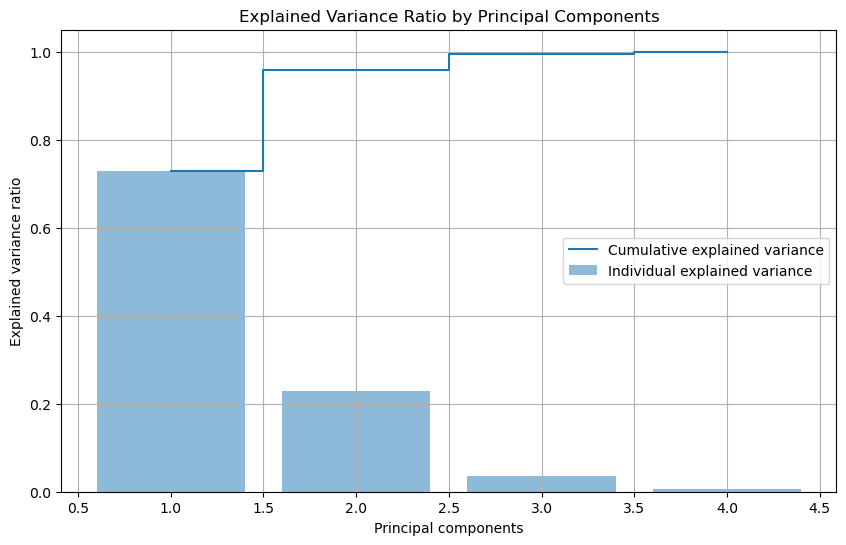

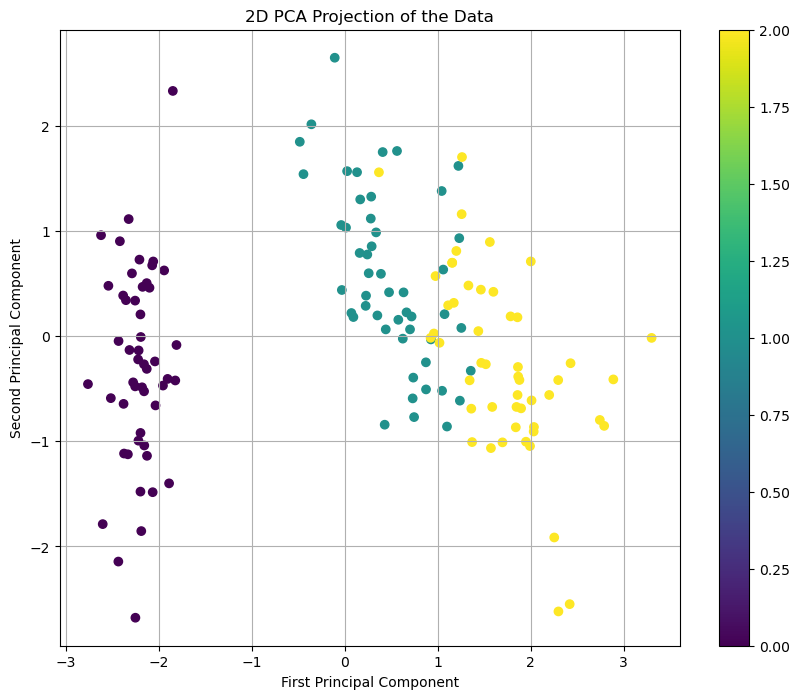

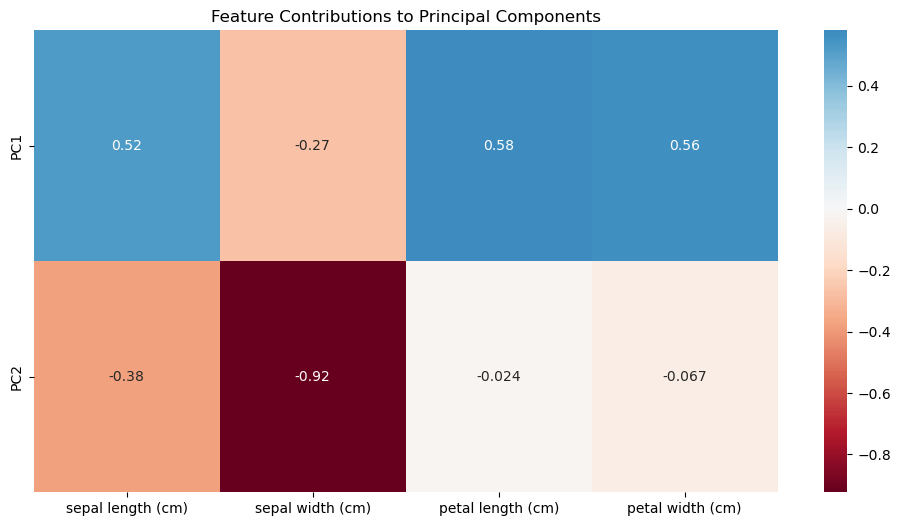


Reconstruction error: 0.0355


In [7]:
if __name__ == "__main__":
    iris = load_iris()
    X, y = iris.data, iris.target
    feature_names = iris.feature_names
    
    pca = PCA(n_components=2, standardize=True)
    X_transformed = pca.fit_transform(X)
    
    print("Explained variance ratio:", pca.explained_variance_ratio)
    print("Total variance explained: {:.2f}%".format(
        np.sum(pca.explained_variance_ratio) * 100))
    
    pca.plot_explained_variance()
    pca.plot_2d_projection(X, y)
    pca.plot_feature_contributions(feature_names)
    
    X_reconstructed = pca.inverse_transform(X_transformed)
    reconstruction_error = np.mean((X - X_reconstructed) ** 2)
    print("\nReconstruction error: {:.4f}".format(reconstruction_error))